In [1]:
%load_ext autoreload
%autoreload 2

# Week 4 - Systematically Improving Your Rag Application

In this notebook, we'll generate a synthetic dataset of user queries based off Klarna's FAQ pages which we'll perform topic modeling on in a subsequent notebook. 


## Why this matters

In large-scale RAG applications, manually reviewing thousands of user conversations isn't feasible. We need systematic ways to understand what users are asking and how well we're serving them. 

By leveraging unstructured techniques such as topic modelling, we're able to identify patterns in general user queries, combine those insights with metrics like query volume and user satisfcation and then from there prioritise improvements where they matter most.

Our goal here is to identify two main query segments 

1. High User Volume, Low User Satisfcation
2. Low User Volume, High User Satisfcation

We want to quickly fix queries that match (1) and make sure that we spend some time thinking about queries that match (2). 

![](./assets/matrix.png)


## What you'll Learn



Through this hands-on tutorial, you'll discover how to:

1. Generate Realistic Queries
- Create diverse test questions
- Match real user writing patterns
- Cover different intents and complexities

2. Add Strategic Diversity
- Vary query types based on real patterns
- Include different user personas
- Test edge cases and common variations

3. Evaluate Query Quality
- Measure semantic diversity
- Check distribution across categories
- Validate query realism

By the end of this notebook, you'll have a dataset of synthetic queries that you can use to perform topic modelling on in a subsequent notebook.


## Case Study: Klarna's Customer Service Chatbot

A while back, Klarna launched it's new customer service chatbot that was powered under the hood by OpenAI's GPT-4 model. This was used as a huge customer story by OpenAI which published a [writeup about it here](https://openai.com/index/klarna/)

In this notebook, we'll simulate the Klarna case study by generating synthetic queries that a user might have based off Klarna's FAQ. We've scrapped their FAQ pages ahead of time and cleaned it so that we have a list of questions with the following fields in the `./data/questions.jsonl` file. The relevant content for each question is stored in the `./data/md` folder under the same slug.

1. `question` : A question from their FAQ
2. `url` : The url slug that this question lives at
3. `parent_category` : The parent category that this question belongs to
4. `child_category` : The child category that this question belongs to

We want to generate a dataset of synthetic queries that are diverse and cover a wide range of topics. We'll do so in 3 steps

1. **Generate Initial Questions** : First, we'll generate some simple questions that are easy to answer using the FAQ
2. **Add Conditions For Diversity** : Then, we'll sample from these initial questions and generate more complex questions by adding more detail and context
3. **Evaluate Generated Questions**Finally, we'll make sure that they're diverse and cover a wide range of topics using metrics such as cosine similarity and average word count.

Throughout this process, we'll be using the `instructor` library to help us generate questions using structured outputs. This allows us to focus on the task at hand and not worry about ensuring that our outputs are valid. We've also provided a simple `label.py` streamlit app that you can use to manually label the questions as either high or low quality similar to Week 2's labelling exercise.

We recommend using this labelling app to help you filter out low quality and repeated generations at each step of the process - both when generating initial questions and when adding diversity to our data set.


### Generating Initial Questions

We'll start by loading in the initial questions and content that we've scrapped from Klarna's FAQ pages. We want to use the chunk_id here as a key because it's easier to sample from and we can ensure that each chunk has a equally likely chance of being sampled.

We'll be loading in the 

1. `questions` : A list of questions that we've scrapped from Klarna's FAQ pages
2. `chunk_to_metadata` : A mapping from a chunk id to the metadata associated with that chunk
3. `chunk_to_content` : A mapping from a chunk id to the content associated with that chunk

We recommend using the `O1` model here to think through what questions might look like before generating any questions. For instance, we might expect questions to mostly be sent by customers when they face problems or encounter errors.

It's therefore unlikely for a customer to send a query like

- Could you tell me how I might avoid being phished with Klarna?
- I'd like to know more about the advantages and disadvantages of using Klarna

Instead queries would probably look like

- I just got an email telling me I've been charged by Klarna for a purchase I didn't make but it's not appearing in the app. What's happening?
- apple pay not working
- can't find klarna option on utility checkout

Most queries are not going to be nicely phrased as a coherent question with perfect grammer too and often times, customers will send messages that are not questions at all. Brainstorming through what some potential questions might look like can help us generate more realistic queries.

Ultimately, we need real user queries because there is a lot of variance in how people ask questions. So ideally you'll be doing this on a regular basis with your real user data, and then using those to generate more synthetic queries to systematically improve your RAG application. 

In order for us to quickly validate if a question can be answered, we want to make sure our model generates citations from the original context. Since our model might make some small formatting errors, we'll use the `fuzzywuzzy` library to make sure the citation matches a substring in the original context with at least 99% similarity.

We want these citations because we can use them when doing the manual curation of our dataset to see if the questions are grounded in the original context.

In [39]:
import json

# Load in questions
with open("./data/questions.jsonl", "r") as f:
    questions = [json.loads(line) for line in f]

chunk_to_metadata = {}
chunk_to_content = {}

# Map chunk_id to metadata
for question in questions:
    chunk_id = question["url"].split("/")[-2]
    chunk_to_metadata[chunk_id] = question

# Map chunk_id to content
for question in questions:
    chunk_id = question["url"].split("/")[-2]
    chunk_to_content[chunk_id] = open(f"./data/md/{chunk_id}.md", "r").read()

categories = set([question["parent_category"] for question in questions])
subcategories = set([question["child_category"] for question in questions])

category_to_chunk_id = {}
for question in questions:
    category = question["parent_category"]
    chunk_id = question["url"].split("/")[-2]
    if category not in category_to_chunk_id:
        category_to_chunk_id[category] = []
    category_to_chunk_id[category].append(chunk_id)


In [40]:
import instructor
from pydantic import BaseModel, field_validator, ValidationInfo
import random
from asyncio import Semaphore
from thefuzz import fuzz


class GeneratedQuestion(BaseModel):
    chain_of_thought: str
    citations: list[str]
    question: str
    answer: str
    sources: list[str]

    @field_validator("sources")
    def validate_sources(cls, v:list[str], info: ValidationInfo):
        if not v:
            raise ValueError("You must provide sources for your generated questions")
        
        for source in v:
            if source not in info.context["sources"]:
                raise ValueError(f"Source {source} not in sources. You must provide the chunk id of the source text that you used to generate the question. Valid options are {info.context['sources']}")

        return v

    @field_validator("citations")
    def validate_citation(cls, v:list[str], info: ValidationInfo):
        context = info.context["context"]

        if not v:
            raise ValueError("You must provide citations for your gneerated questions")


        invalid_citations = []
        for citation in v:
            if citation in context:
                continue

            ratio = fuzz.partial_ratio(context, citation)
            if ratio <= 95:
                invalid_citations.append(citation)
        
        if invalid_citations:
            formatted_citations = '\n'.join(invalid_citations)
            raise ValueError(
                f"""
Citations should be an exact match from the source text they appear in. The following citations do not match the source text exactly.
<citations>
{formatted_citations} 
</citations>

<source_text>
{context}
</source_text>

Look carefully at the context and make sure each citation is provided as it appears in the source text. Make sure to preserve all markdown formatting that was originally provided
"""
            )

        return v


class Question(BaseModel):
    question: str
    answer: str
    category: str
    citations: list[str]
    subcategory: str
    sources:list[str]

    @field_validator("category")
    def validate_category(cls, v):
        if v not in categories:
            raise ValueError(f"Category {v} not in categories")
        return v

    @field_validator("subcategory")
    def validate_subcategory(cls, v):
        if v not in subcategories:
            raise ValueError(f"Subcategory {v} not in subcategories")
        return v


In [28]:
async def generate_question(
    client: instructor.AsyncInstructor,
    context: str,
    category: str,
    subcategory: str,
    sources: list[str],
    sem: Semaphore,
):
    async with sem:
        resp = await client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant that generates question and answer pairs based on provided context. The answer must include citations that exactly match text from the original context."
                },
                {
                    "role": "user",
                    "content": """
Generate a question and answer pair based on the following context you're provided with. For the question that you generate, make sure that you provide citations for where the answer can be derived from. These citations should be the sentences that the answer is extracted from.

These citations must be directly lifted from the context itself and appear exactly as they are written in the context. This includes markdown formatting, links and anything else that appears in the original text. 

<context>
{{context}}
</context>

Category: {{category}}
Subcategory: {{subcategory}}
"""
                }
            ],
            response_model=GeneratedQuestion,
            context={
                "context": context,
                "category": category,
                "subcategory": subcategory,
                "sources": sources
            },
        )

        return Question(
            question=resp.question,
            answer=resp.answer,
            citations=resp.citations,
            category=category,
            subcategory=subcategory,
            sources=resp.sources
        )


In [41]:
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio as asyncio


client = instructor.from_openai(AsyncOpenAI())

# Define a semaphore here to limit the number of concurrent requests so that we don't get rate limited out of nowhere.
sem = Semaphore(10)
number = 10

coros = []
for _ in range(number):
    # Sample a random chunk, category and subcategory
    chosen_category = random.choice(list(category_to_chunk_id.keys()))
    chosen_chunk = random.choice(category_to_chunk_id[chosen_category])
    chosen_subcategory = chunk_to_metadata[chosen_chunk]["child_category"]
    chosen_chunk_content = f"<chunk id={chosen_chunk}>{chunk_to_content[chosen_chunk]}</chunk>"
    coros.append(
        generate_question(
            client, chosen_chunk_content, chosen_category, chosen_subcategory, [chosen_chunk],sem
        )
    )

resp = await asyncio.gather(*coros, total=number)

with open("./data/synthetic_questions.jsonl", "w") as f:
    for question in resp:
        f.write(json.dumps(question.model_dump()) + "\n")






































100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


### Adding Diversity

We want to have a diverse set of questions to do topic modelling with. If we use the same prompt over and over again, we'll end up getting the same kind of questions over and over. In that case, we'll only be wasting our tokens. 

In order to add more diversity, we want to vary our prompt. To do so, we'll vary the following parameters 

1. **Category** : We'll vary the specific category that the question belongs to
3. **Length**: We'll ask the model to generate questions that are short, medium or long in nature
4. **Intent** : We want to vary the intent by category and subcategory. This will allow us to generate questions that are more specific to certain types of queries
5. **Personas**: We'll condition the generation of questions on different persona types to help generate more diverse questions

We'l do so by configuring a `config.yml` file that's located in the root of our project. This will allow us to easily change the parameters and generate more diverse questions. We'll read in this file using a classmethod on the `QuestionGenerationConfig` class and then randomly sample from the different configuration values to generate our questions.

By doing so, we'll be able to generate a greater variety of questions by conditioning the generated question on these parameters. This is a simple way to add some diversity. If you'd like to go beyond this, some things that you can try are

1. **Generating complex personas** : You can use a language model to generate complex personas that have backstories and then generate questions based off those personas.
2. **Varying the kinds of questions generated** : You can condition the generation of questions on the kinds of questions you'd like to generate. For instance, you can condition on whether the question is about a specific product, a general question, ask for multi-hop questions that combine different chunks of information.

When doing these variations, we always want to define a simple Config object that contains the different parameters that we want to vary the questions by. This allows us to easily change the parameters and generate more diverse questions. 

In [21]:
import random
from dataclasses import dataclass
import yaml
from rich import print


@dataclass
class QuestionGenerationConfig:
    user_intent: str
    length: str
    persona: str
    category: str
    subcategory: str

    @classmethod
    def generate_config_for_category(cls, category: str):
        with open("./config.yml", "r") as file:
            config = yaml.load(file, Loader=yaml.FullLoader)

        length = random.choice(config["length"])
        persona = random.choice(config["persona"])
        subcategory = random.choice(list(config["customer_intents"][category].keys()))
        intent = random.choice(list(config["customer_intents"][category][subcategory]))
        return cls(
            user_intent=intent,
            category=category,
            subcategory=subcategory,
            length=length,
            persona=persona,
        )

    @classmethod
    def generate_config(cls):
        with open("./config.yml", "r") as file:
            config = yaml.load(file, Loader=yaml.FullLoader)

        length = random.choice(config["length"])
        persona = random.choice(config["persona"])

        category = random.choice(list(config["customer_intents"].keys()))
        subcategory = random.choice(list(config["customer_intents"][category].keys()))
        intent = random.choice(list(config["customer_intents"][category][subcategory]))
        return cls(
            length=length,
            persona=persona,
            user_intent=intent,
            category=category,
            subcategory=subcategory,
        )


config = QuestionGenerationConfig.generate_config_for_category("Refunds")
print(config)

QuestionGenerationConfig(
    user_intent='user wants to report nike for not responding to requests',
    length="medium message that's straight to the point",
    persona="someone that's not tech savvy and wants to use klarna for the first time",
    category='Refunds',
    subcategory='Manage refunds'
)

In [86]:
import instructor


async def generate_question_with_config(
    client: instructor.AsyncInstructor,
    config: QuestionGenerationConfig,
    context:str,
    examples: list[Question],
    chunk_ids: list[str],
    sem: Semaphore,
):
    async with sem:
        resp = await client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": """
Generate a hypothetical question that a customer might send to a customer support chatbot for Klarna and an answer to that specific question that is grounded in the context provided. Make sure to look closely at the examples provided, but make sure to mention a different product, location or time frame in your generated question. 

Think carefully about the context provided, the citations that you've identified and the examples provided before starting to generate your question.

Please follow these guidelines:
1. Create realistic customer scenarios with specific details:
   - Include actual purchases with brand names, product types, and prices (minimum ${{ min_price }})
   - Mention specific timeframes (e.g., "ordered 3 days ago", "payment due tomorrow")

2. Citations requirements:
   - You must provide at least cited sentence in the generated response to show where you derived your question and answer from
   - All citations must be exact verbatim extracts from the provided context
   - Preserve all original formatting including markdown, links, and punctuation
   - Citations should be the sentences that the answer is extracted from.
   - Sources must be provided using the chunk ids provided in the context. These will map to the original different chunks of text that you used to generate the question.

3. Match the specified configuration exactly:
   - Adhere to the requested message length ({{config.length}})
   - Align with the user intent: "{{config.user_intent}}"
   - Write in the voice of the specified persona: "{{config.persona}}"
   - Stay within the category "{{config.category}}" and subcategory "{{config.subcategory}}"

4. Style guidelines:
   - Use natural language that reflects how real customers communicate
   - Avoid customer service jargon (e.g., say "money I added" instead of "Klarna balance")
   - Express appropriate emotion (frustration, confusion, urgency) based on the scenario
   - Frame as statements or requests rather than using question words (how, what, when, why)
   - For short messages, be direct and concise

5. Content approach:
   - Synthesize information from multiple context chunks when relevant
   - Create a scenario where the customer lacks complete information (e.g., unaware of standard waiting periods)
   - Make the message distinct from all provided examples

<context>
{{context}}
</context>

Sample previous customer messages:
{% for question in examples %}
{{ loop.index }}: {{ question.question }}
{% endfor %}

Configuration:
- Length: {{config.length}}
- User intent: {{config.user_intent}}
- Customer persona: {{config.persona}}
- Category: {{config.category}}
- Subcategory: {{config.subcategory}}

Remember that this must be a question that a user would send. 
                    """,
                }
            ],
            response_model=GeneratedQuestion,
            context={
                "config": config,
                "context": context,
                "examples": examples,
                "sources": chunk_ids,
                "min_price": random.randint(30, 200),
            },
        )

        return Question(
            question=resp.question,
            answer=resp.answer,
            citations=resp.citations,
            category=config.category,
            subcategory=config.subcategory,
            sources=resp.sources
        )

In [94]:
import json
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio as asyncio
import instructor

with open("./data/cleaned.jsonl", "r") as f:
    saved_questions = [Question(**json.loads(line)) for line in f]

client = instructor.from_openai(AsyncOpenAI())


sem = Semaphore(20)
number = 10

coros = []
for _ in range(number):
    config = QuestionGenerationConfig.generate_config_for_category("Payments")

    # We get a single random chunk that belongs to the category
    valid_chunk_ids = [
        chunk_id
        for chunk_id in chunk_to_metadata.keys()
        if chunk_to_metadata[chunk_id]["parent_category"] == config.category
    ]
    # Select 1-3 random chunks
    num_chunks = random.randint(1, 3)
    selected_chunk_ids = random.sample(valid_chunk_ids, min(num_chunks, len(valid_chunk_ids)))
    chunk_context = ""
    for chunk_id in selected_chunk_ids:
        chunk_context += f"<chunk id={chunk_id}>{chunk_to_content[chunk_id]}</chunk>"

    valid_examples = [q.question for q in saved_questions if q.category == config.category]
    examples = random.sample(valid_examples, random.randint(0, min(len(valid_examples),5)))

    coros.append(
        generate_question_with_config(
            client=client,
            context=chunk_context,
            examples=examples,
            config=config,
            sem=sem,
            chunk_ids=selected_chunk_ids
        )
    )

resp = await asyncio.gather(*coros, total=number)
with open("./data/synthetic_questions.jsonl", "w") as f:
    for question in resp:
        f.write(json.dumps(question.model_dump()) + "\n")


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


In [95]:
with open("./data/cleaned.jsonl", "r") as f:
    questions = [Question(**json.loads(line)) for line in f]

counts = {}
for question in questions:
    counts[question.category] = counts.get(question.category, 0) + 1

counts, len(questions)


({'Account & settings': 9,
  'Delivery & returns': 19,
  'Declined purchase': 40,
  'Fraud & security': 27,
  'Products & services': 41,
  'Refunds': 10,
  'Payments': 26},
 172)

### Evaluating Generated Questions

We want to make sure that our questions are diverse and cover a wide range of topics. 

To do so, we'll evaluate our questions using two main methods

1. Cosine Similiarity: We want to make sure there's a good spread of cosine similarity scores in each category. If a category has a low variance, it means that there are some questions that are very similar to each other and we might want to generate more diverse questions.
2. Word Length: We also want to make sure that the questions have a good spread of word lengths. If a category has a low variance, it means that there are some questions that are very short or very long and we might want to generate more diverse questions.

Ultimately depending on your specific use case, you might want to evaluate your generated questions using a combination of these methods. The main goal here is to just get a sense for how diverse your generated questions are.

In [96]:
from asyncio import Semaphore
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio as asyncio


async def generate_embedding_for_question(
    client: AsyncOpenAI, question: dict[str, str], sem: Semaphore
):
    async with sem:
        resp = await client.embeddings.create(
            model="text-embedding-3-small",
            input=question["question"],
        )
        embedding = resp.data[0].embedding
        return {
            "question": question["question"],
            "embedding": embedding,
            "category": question["category"],
            "subcategory": question["subcategory"],
        }


client = instructor.from_openai(AsyncOpenAI())

questions = []
with open("./data/cleaned.jsonl", "r") as f:
    for line in f:
        item = json.loads(line)
        questions.append(
            {
                "question": item["question"],
                "category": item["category"],
                "subcategory": item["subcategory"],
            }
        )

sem = Semaphore(20)
coros = [generate_embedding_for_question(client, q, sem) for q in questions]
resp = await asyncio.gather(*coros, total=len(questions))

  0%|          | 0/168 [00:00<?, ?it/s]

100%|██████████| 168/168 [00:28<00:00,  5.93it/s]


In [97]:
# Convert embeddings to numpy array for similarity calculation
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Extract embeddings and organize by category
questions_by_category = {}
embeddings_by_category = {}

for item in resp:
    category = item["category"]
    if category not in questions_by_category:
        questions_by_category[category] = []
        embeddings_by_category[category] = []

    questions_by_category[category].append(item["question"])
    embeddings_by_category[category].append(item["embedding"])

# Calculate pairwise similarities within each category
category_similarities = {}
for category in questions_by_category:
    embeddings = np.array(embeddings_by_category[category])
    similarities = cosine_similarity(embeddings)

    # Get upper triangle values (excluding diagonal)
    mask = np.triu_indices(len(similarities), k=1)
    upper_tri_similarities = similarities[mask]

    category_similarities[category] = {
        "mean": float(np.mean(upper_tri_similarities)),
        "std": float(np.std(upper_tri_similarities)),
        "min": float(np.min(upper_tri_similarities)),
        "max": float(np.max(upper_tri_similarities)),
        "num_questions": len(embeddings),
    }


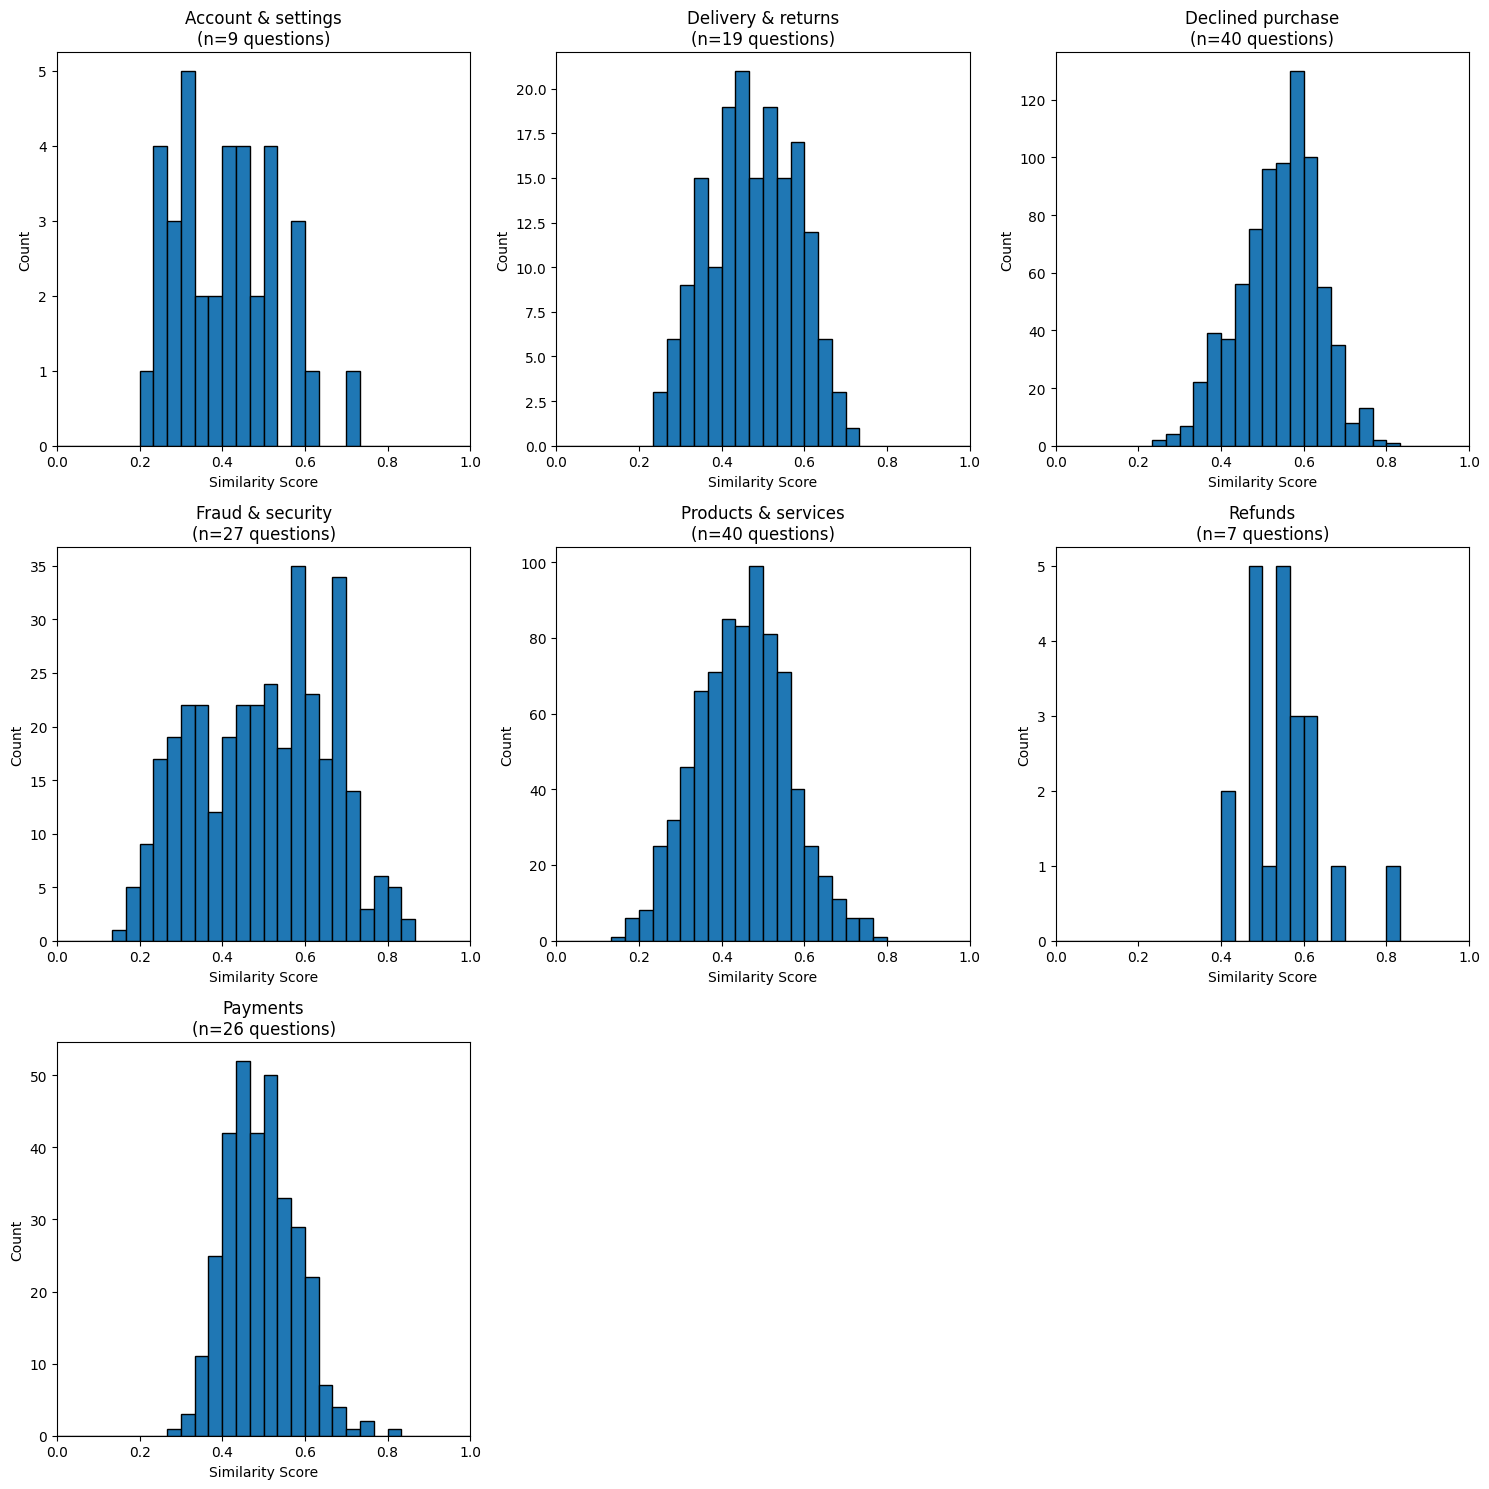

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Get categories in a consistent order
categories = list(category_similarities.keys())

# Calculate number of rows needed (2 categories per row)
n_categories = len(categories)
n_rows = (n_categories + 2) // 3  # Round up division

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create histogram for each category
for i, category in enumerate(categories):
    embeddings = np.array(embeddings_by_category[category])
    similarities = cosine_similarity(embeddings)

    # Get upper triangle values (excluding diagonal)
    mask = np.triu_indices(len(similarities), k=1)
    similarities = similarities[mask]

    # Plot histogram
    axes[i].hist(similarities, bins=30, edgecolor="black", range=(0, 1))
    axes[i].set_title(f"{category}\n(n={len(embeddings)} questions)")
    axes[i].set_xlabel("Similarity Score")
    axes[i].set_ylabel("Count")
    axes[i].set_xlim(0, 1)

# Remove any empty subplots
for i in range(n_categories, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


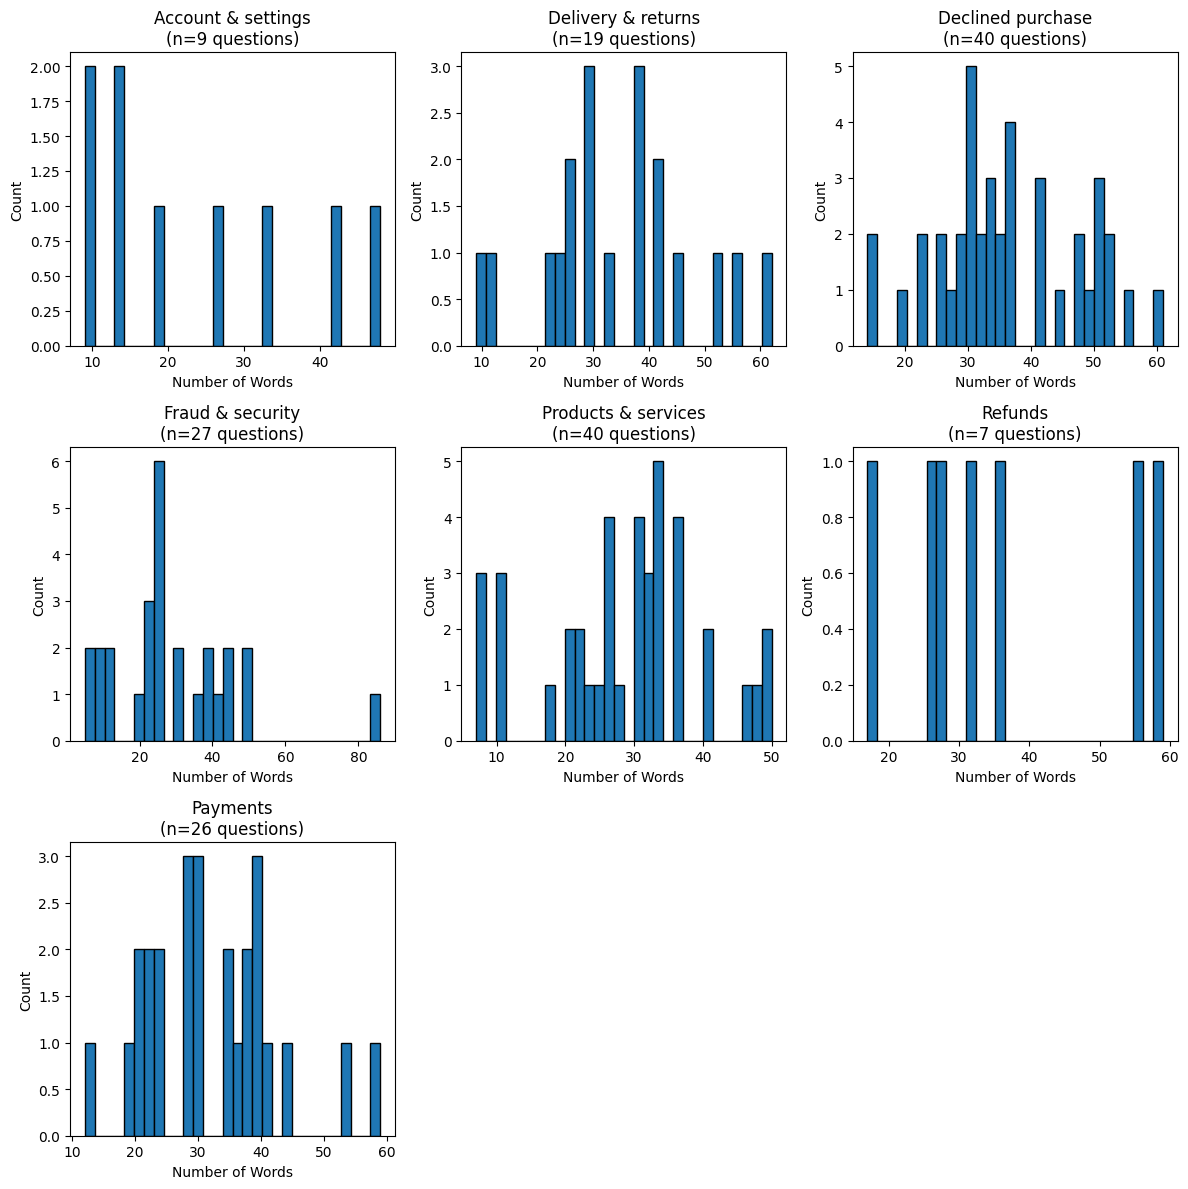

In [99]:
# Get word lengths for all questions by category
words_by_category = {}
for category in categories:
    filtered_questions = [q for q in questions if q["category"] == category]
    words = [len(q["question"].split()) for q in filtered_questions]
    words_by_category[category] = words

# Create subplots for each category
n_categories = len(categories)
n_rows = (n_categories + 2) // 3  # Round up division
fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Create histogram for each category
for i, category in enumerate(categories):
    axes[i].hist(words_by_category[category], bins=30, edgecolor='black')
    axes[i].set_title(f"{category}\n(n={len(words_by_category[category])} questions)")
    axes[i].set_xlabel('Number of Words')
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for i in range(n_categories, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've built a foundation for understanding user queries by:
1. Creating diverse synthetic questions based on Klarna's FAQ data
2. Adding strategic variation through personas and query types 
3. Validating our dataset using semantic similarity and length distribution

Looking at our evaluation metrics, we can see we've achieved good diversity - our questions vary both semantically and in length across different topics. This suggests we've created a realistic dataset that captures the range of ways users might ask questions, rather than just generating variations of the same few patterns.

This synthetic dataset gives us a starting point but in practice, you'll want to continuously update your understanding using real user queries and satisfaction metrics. While synthetic data helps us get started, real user interactions will reveal patterns we might never think to simulate.

In the next notebook, we'll use this dataset to perform topic modeling, helping us identify clusters of related queries. By combining these clusters with metrics like query volume and user satisfaction, we can make smart decisions about where to focus our improvement efforts where it's implementing better tool selection in week 6 or our leveraging LLM-generated metadta in week 5.